# Settings

In [4]:

import os
import sys

from google.colab import drive
drive.mount('/content/drive')  ## connect to personal google drive to use as a working directory

wd_path='/content/drive/MyDrive/cod/unioviedo_assessment' # establish folder in drive as a working directory and add it to the system path

os.chdir(wd_path)
sys.path.append(wd_path)

Mounted at /content/drive


In [5]:
#### Libraries to use ####################

### Basic ones #####
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns


####### tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

## sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report, confusion_matrix

###others
import shap
import joblib

#### udf

from utils import generate_medical_ts, transf_inputs

In [6]:
#### to asure reproducibility
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# Section 3: Practical question II

## 1.Data simulated based on UDF:

A timeseries was generated for each patient's feature, algorithm was used. An irregular timestamp was established using a time counter that could be interpreted as representing months, years, or days and periods with no values are missing



In [7]:
df=generate_medical_ts(n_users=2000, n_timesteps=30, SEED=SEED)
print(df.head(), df.shape, df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_id     60000 non-null  int64  
 1   timestamp      60000 non-null  int64  
 2   HeartRate      47864 non-null  float64
 3   BloodPressure  47864 non-null  float64
 4   RespRate       47864 non-null  float64
 5   Temperature    47864 non-null  float64
 6   WBC            47864 non-null  float64
 7   Glucose        47864 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB
   patient_id  timestamp  HeartRate  BloodPressure  RespRate  Temperature  \
0           1          1   0.997345       1.738370  0.406454     0.322106   
1           1          2   1.342736      -3.072271 -2.452299    -1.634574   
2           1          3  -3.071381      -3.289789 -1.332844    -1.987330   
3           1          4  -2.378395      -2.474350 -2.038632    -0.743074   
4           1    

## 2.Interpolation

In [8]:
## A interpolation with a linear function was used to deal with intervals that was missing
df_inter = df.set_index('timestamp').interpolate(method='linear', axis=0)
df_inter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60000 entries, 1 to 30
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_id     60000 non-null  int64  
 1   HeartRate      60000 non-null  float64
 2   BloodPressure  60000 non-null  float64
 3   RespRate       60000 non-null  float64
 4   Temperature    60000 non-null  float64
 5   WBC            60000 non-null  float64
 6   Glucose        60000 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 3.7 MB


In [9]:
### this function creates labels based on LSTM NN and return full df with labels and also in separate arrays to process with keras API

df,X, y, ids, timestamps, feat_labels= transf_inputs(df_inter, SEED=SEED)

df.head(), X.shape, y.shape, ids, timestamps, feat_labels,df['label'].value_counts()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


(   timestamp  patient_id  HeartRate  BloodPressure  RespRate  Temperature  \
 0          1           1   0.997345       1.738370  0.406454     0.322106   
 1          2           1   1.342736      -3.072271 -2.452299    -1.634574   
 2          3           1  -3.071381      -3.289789 -1.332844    -1.987330   
 3          4           1  -2.378395      -2.474350 -2.038632    -0.743074   
 4          5           1  -5.408247      -4.749092 -4.784373    -3.884433   
 
         WBC   Glucose        label  
 0 -0.051518 -0.204201       Stable  
 1  0.961250 -1.261527       Stable  
 2 -4.063240  1.037682  Progressing  
 3 -2.002223 -5.107157  Progressing  
 4 -3.458685 -7.247859  Progressing  ,
 (2000, 30, 6),
 (2000, 30),
 array([   1,    2,    3, ..., 1998, 1999, 2000]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 ['HeartRate', 'BloodPressure', 'RespRate', 'Temperature', 'WBC', 'Glucose'],
 labe

In [10]:
### Apply a label encoder to target variable

le = LabelEncoder()

y_flat=y.flatten()
y_falt = le.fit_transform(y_flat)
y = y_falt.reshape(2000,30)
y.shape


(2000, 30)

## 3.Train the model


In [11]:
##train and test split for out of sample evaluation
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=SEED)
x_train.shape, y_train.shape

((1600, 30, 6), (1600, 30))

In [ ]:

tf.config.experimental.enable_op_determinism() ## make the nn training reproducible

n_timesteps = X.shape[1]  # 30 time steps
n_features = X.shape[2]   # 6 features per timestep


# Define the model
model = Sequential([
    Input(shape=(n_timesteps, n_features)),
    LSTM(64, return_sequences=True),  # 64 units used, retunr sequence to keep 30 samples per user
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dense(32, activation='relu'),  # Fully connected layer before output layer as usual architecture
    Dense(3, activation='softmax')  # 3 classes: Stable, Progressing, Critical
])

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.7035 - loss: 0.7743 - val_accuracy: 0.7931 - val_loss: 0.4971
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7966 - loss: 0.4996 - val_accuracy: 0.8233 - val_loss: 0.4410
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.8170 - loss: 0.4532 - val_accuracy: 0.8236 - val_loss: 0.4236
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8227 - loss: 0.4284 - val_accuracy: 0.8309 - val_loss: 0.4028
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8318 - loss: 0.4058 - val_accuracy: 0.8279 - val_loss: 0.4078
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8350 - loss: 0.3908 - val_accuracy: 0.8343 - val_loss: 0.3939
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8419 - loss: 0.3759 - val_accuracy: 0.8370 - val_loss: 0.3875
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8463 - loss: 0.3644 - val_accuracy: 0.8475 - v

In [ ]:

## save trained model
model.save('outputs/lstm_model.keras')


## 4.Model Evaluation

In [13]:

##load the saved model
model = tf.keras.models.load_model('outputs/lstm_model.keras')


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      1396
           1       0.82      0.81      0.82      3283
           2       0.93      0.93      0.93      7321

    accuracy                           0.87     12000
   macro avg       0.81      0.81      0.81     12000
weighted avg       0.87      0.87      0.87     12000



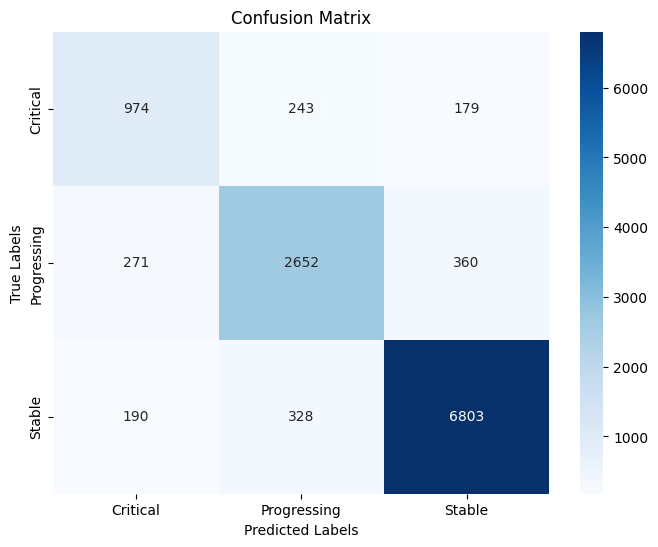

In [14]:
# Predict on the test set
y_pred = model.predict(x_test)
y_pred.shape
y_pred_classes = np.argmax(y_pred, axis=-1) # Convert probabilities to class labels
y_pred_classes_flat = y_pred_classes.flatten()

# Flatten y_test for compatibility with classification_report
y_test_flat = y_test.reshape(-1)

# Generate classification report
print(classification_report(y_test_flat, y_pred_classes_flat))

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test_flat, y_pred_classes_flat)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_) # Use label encoder classes
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


The model performs well with an overall accuracy of 87%, effectively classifying most cases across all three categories. It shows particularly strong performance in identifying Progressing cases with a 93% recall, but struggles with distinguishing between Critical and Progressing, leading to some misclassifications. The F1-scores for all classes are balanced, indicating that the model maintains a good trade-off between precision and recall. Despite this, the model could benefit from further tuning to reduce the confusion between Critical and Progressing categories.

## 5.Explanations

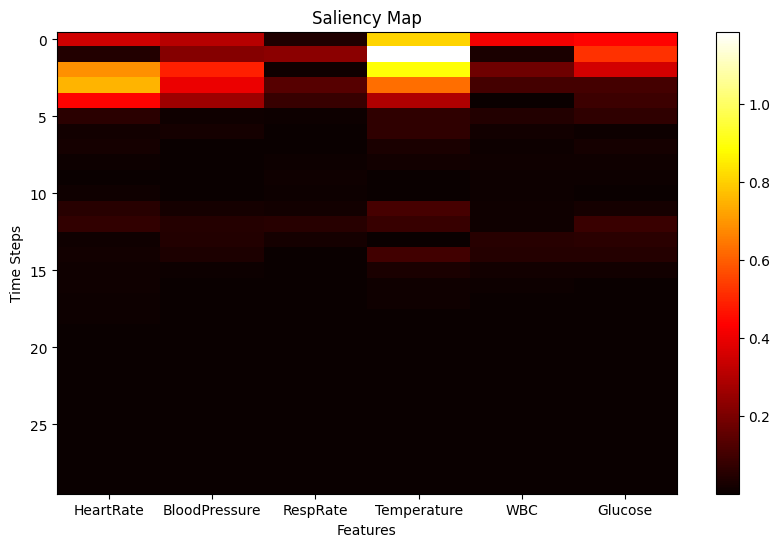

In [15]:

###Samples to explain
sample_input = X[0:3]
sample_label = y[0:3]

# Ensure the model is in "train" mode for gradient calculations
model.trainable = True

# Use GradientTape to compute the gradients
with tf.GradientTape() as tape:
    sample_input_tensor = tf.convert_to_tensor(sample_input, dtype=tf.float32)
    tape.watch(sample_input_tensor)
    predictions = model(sample_input_tensor)
    loss = tf.keras.losses.sparse_categorical_crossentropy(sample_label, predictions)

# Compute the gradients of the loss with respect to the input
gradients = tape.gradient(loss, sample_input_tensor)

# Get the absolute value of the gradients (to understand magnitude of change)
saliency = np.abs(gradients.numpy())


## graph

plt.figure(figsize=(10, 6))
plt.imshow(saliency[0], cmap='hot', aspect='auto')
plt.colorbar()
plt.xticks(ticks=np.arange(len(feat_labels)), labels=feat_labels)
plt.title('Saliency Map')
plt.xlabel('Features')
plt.ylabel('Time Steps')
plt.show()

**Explanation Discussion:**

The saliency map reveals that 'Temperature' consistently shows higher saliency across multiple time steps, suggesting that it plays a crucial role in the model's decision-making process. Additionally, the early time steps (0 to 5) have the highest saliency, highlighting that the model places considerable importance on the initial observations of the time series.

Given that the time series was constructed with an underlying trend, it was expected that the model's focus on these early time steps and specific features suggests that these parts of the sequence are likely where the most valuable information lies for predicting disease progression.

The saliency map allows clinicians to identify critical periods in a patient's progression. For instance, as the saliency map shows, early changes in Temperature are significant for predicting a shift to a more critical disease state, clinicians can focus on early intervention or monitoring during the initial periods (0 to 5 time steps), as these are the points the model identifies as most informative.

Additionally, by visually aligning the features that influence predictions, clinicians can correlate these insights with their own medical knowledge. This could help them recognize early warning signs of worsening conditions, identify trends before they become acute, and tailor interventions more effectively.

